# GPS and INS
Position and orientation of Polar 5 and Polar 6 are recorded by an on-board GPS sensor and the internal navigation system (INS). The following example presents the variables recored by these instruments.

## Data access
To analyse the data they first have to be loaded by importing the (AC)³ airborne meta data catalogue. To do so the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue). Since some of the data, like the preliminary data of the HALO-(AC)<sup>3</sup> campaign, is stored on the (AC)<sup>3</sup> nextcloud server, username and password as credentials ([registration](https://cloud.ac3-tr.de/index.php/login)) are required and need to be loaded from environment variables. 

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# local caching
kwds = {'simplecache': dict(
    cache_storage=os.environ['INTAKE_CACHE'], 
    same_names=True
)}

In [2]:
import ac3airborne

## Get data

All flights of Polar 5:

In [3]:
cat = ac3airborne.get_intake_catalog()
meta = ac3airborne.get_flight_segments()
flights_p5 = {}
for campaign in ['ACLOUD', 'PAMARCMiP', 'AFLUX', 'MOSAiC-ACA','HALO-AC3']:
    flights_p5.update(meta[campaign]['P5'])

All flights of Polar 6:

In [4]:
flights_p6 = {}
for campaign in ['ACLOUD', 'HALO-AC3']:
    flights_p6.update(meta[campaign]['P6'])

```{note}
Have a look at the attributes of the xarray dataset `ds_gps_ins` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [ ]:
ds_gps_ins = cat['AFLUX']['P5']['GPS_INS']['AFLUX_P5_RF10'](storage_options=kwds).to_dask()
ds_gps_ins

<xarray.Dataset>
Dimensions:  (time: 17808)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-03T10:06:26 ... 2019-04-03T15:03:23
Data variables:
    alt      (time) float64 ...
    gs       (time) float64 ...
    lat      (time) float64 ...
    lon      (time) float64 ...
    vs       (time) float64 ...
    pitch    (time) float64 ...
    roll     (time) float64 ...
    heading  (time) float64 ...
Attributes: (12/15)
    title:          P5 position and attitude data
    description:    1 Hz subset based on GPS1 and INS data processed by AWI e...
    instruments:    GPS1 and INS
    version:        1.1
    institution:    Alfred-Wegener-Institut Helmholtz-Zentrum für Polar- und ...
    author:         Dr. Mario Mech
    ...             ...
    featureType:    trajectory
    mission:        AFLUX
    platform:       P5
    flight_number:  RF10
    history:        acquired by P5 during AFLUX campaign, quality checked by ...
    created:        2022-05-25

The dataset `ds_gps_ins` includes the aircraft's position (`lon`, `lat`, `alt`), attitude (`roll`, `pitch`, `heading`), and the ground speed, vertical speed and true air speed (`gs`, `vs`, `tas`). 

## Load flight phase information
Polar 5 flights are divided into segments to easily access start and end times of flight patterns. For more information have a look at the respective [github](https://github.com/igmk/flight-phase-separation) repository.

At first we want to load the flight segments of (AC)³ airborne

In [6]:
meta = ac3airborne.get_flight_segments() # this happened before, but it doesn't hurt.

The following command lists all flight segments into the dictionary `segments`:

In [7]:
segments = {s.get("segment_id"): {**s, "flight_id": flight["flight_id"]}
             for campaign in meta.values()
             for platform in campaign.values()
             for flight in platform.values()
             for s in flight["segments"]
            }

In this example, we want to look at a racetrack pattern during `ACLOUD_P5_RF10`.

In [8]:
seg = segments["AFLUX_P5_RF10_rt01"]

Using the start and end times of the segment, we slice the data to this flight section.

In [9]:
ds_gps_ins_rt = ds_gps_ins.sel(time=slice(seg["start"], seg["end"]))

## Plots

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import ipyleaflet
from simplification.cutil import simplify_coords_idx
plt.style.use("../../mplstyle/book")

### Plot all flights

In [11]:
def simplify_dataset(ds, tolerance):
    indices_to_take = simplify_coords_idx(np.stack([ds.lat.values, ds.lon.values], axis=1), tolerance)
    return ds.isel(time=indices_to_take)

In [12]:
# define colors for the flight tracks
colors = [mcolors.to_hex(c)
          for c in plt.cm.inferno(np.linspace(0, 1, len(flights_p5)))]

In [13]:
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.NatGeoWorldMap,
                   center=(80., 6), zoom=3)

for (flight_id, flight),color in zip(flights_p5.items(),colors):
    mission = flight['mission']
    # read gps dataset of flight
    ds = cat[mission]['P5']['GPS_INS'][flight_id].to_dask()
    
    # slice to takeoff and landing times
    ds = ds.sel(time=slice(meta[mission]['P5'][flight_id]['takeoff'], meta[mission]['P5'][flight_id]['landing']))
    
    # reduce dataset for plotting
    ds_reduced = simplify_dataset(ds, tolerance=1e-5)
    
    track = ipyleaflet.Polyline(
        locations=np.stack([ds_reduced.lat.values, 
                            ds_reduced.lon.values], axis=1).tolist(), 
        color=color,
        fill=False,
        weight=2,
        name=flight_id)
    
    m.add_layer(track)
    
m.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
m.add_control(ipyleaflet.LegendControl(dict(zip(flights_p5.keys(), colors)),
                                       name="Flights",
                                       position="bottomright"))
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())
display(m)

Map(center=[80.0, 6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

### Plot time series of one flight

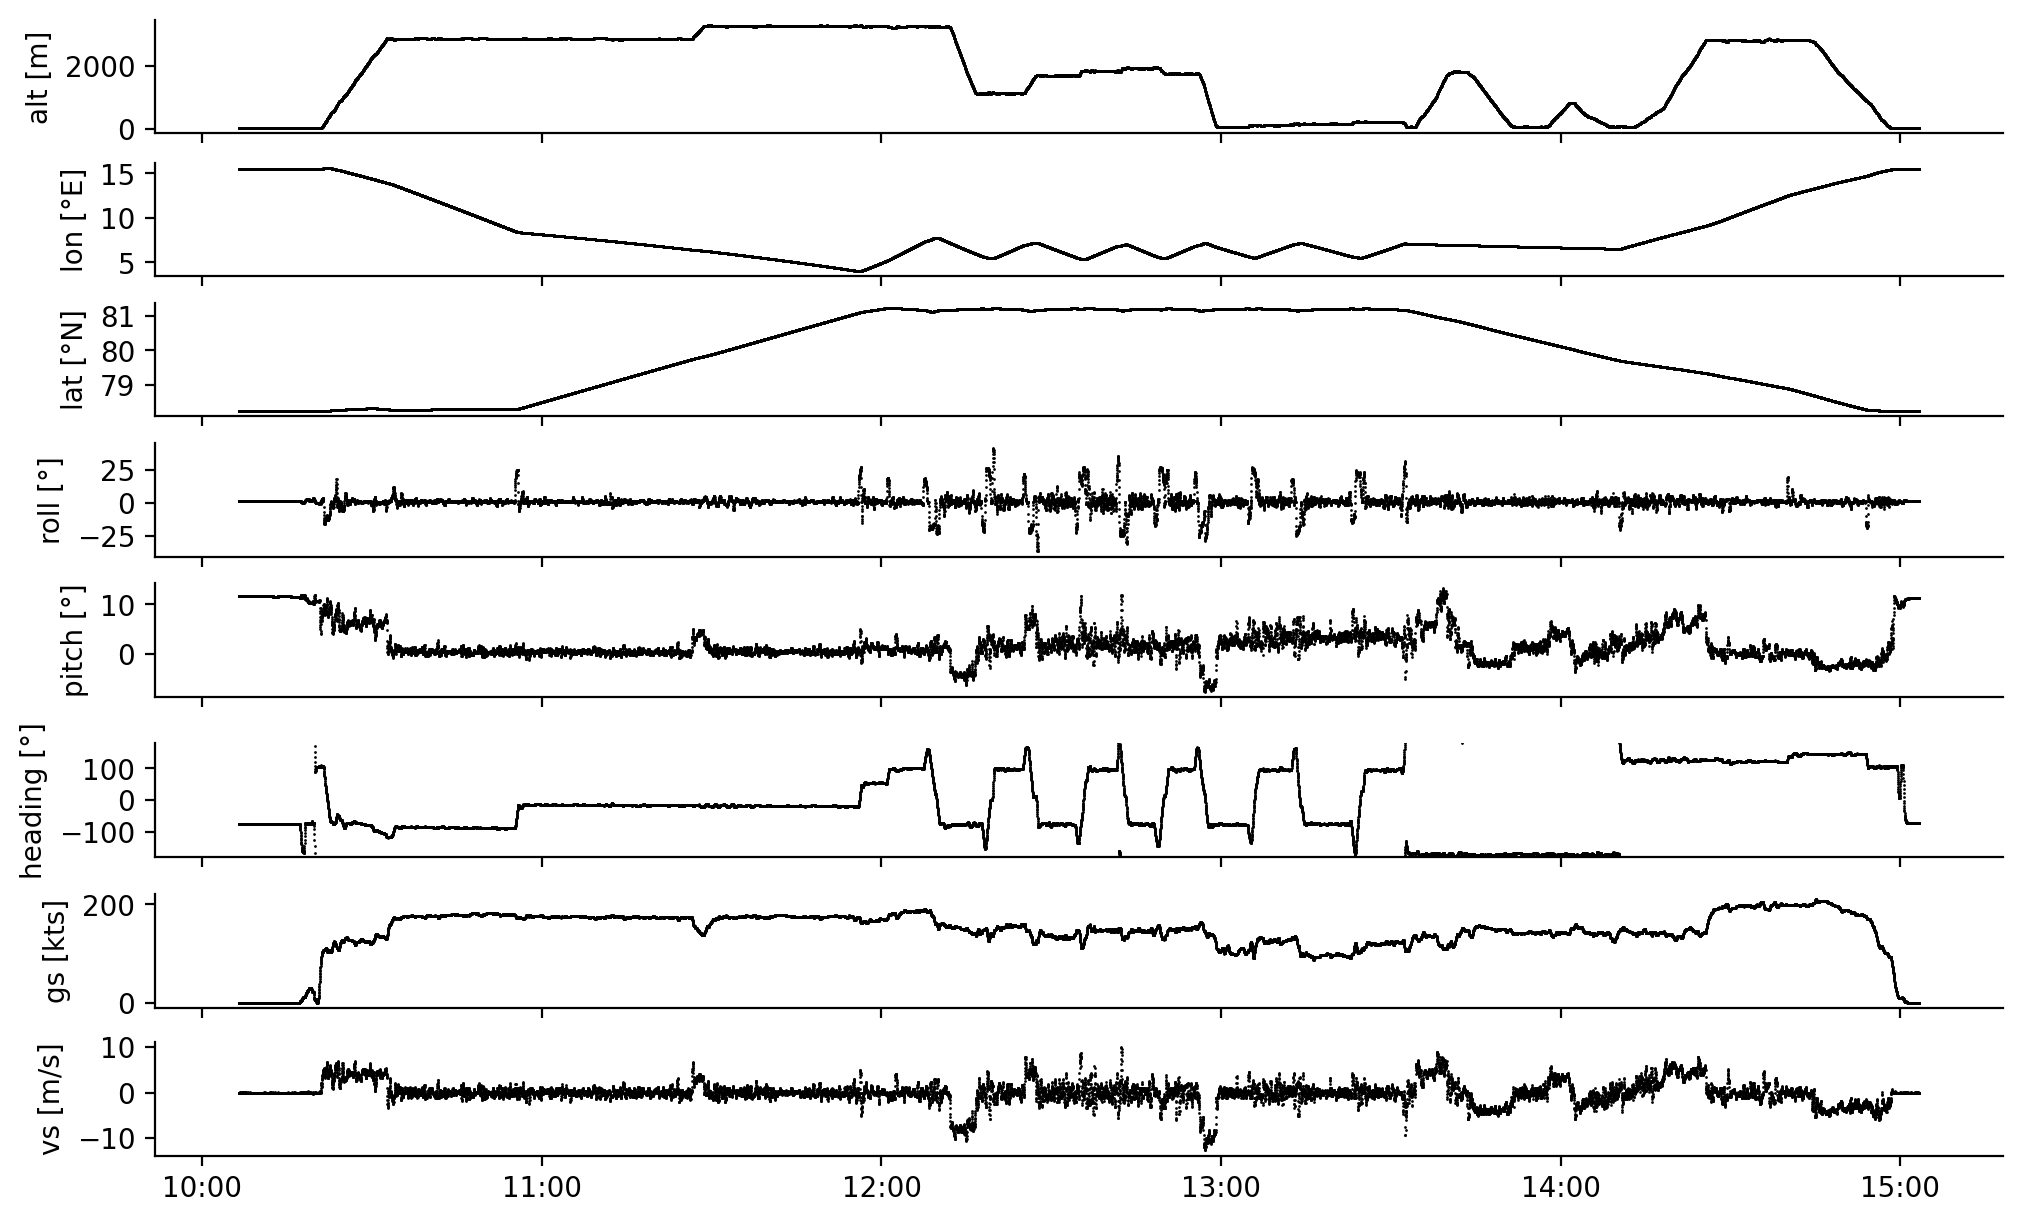

In [14]:
fig, ax = plt.subplots(8, 1, sharex=True)

kwargs = dict(s=1, linewidths=0, color='k')

ax[0].scatter(ds_gps_ins.time, ds_gps_ins['alt'], **kwargs)
ax[0].set_ylabel('alt [m]')

ax[1].scatter(ds_gps_ins.time, ds_gps_ins['lon'], **kwargs)
ax[1].set_ylabel('lon [°E]')

ax[2].scatter(ds_gps_ins.time, ds_gps_ins['lat'], **kwargs)
ax[2].set_ylabel('lat [°N]')

ax[3].scatter(ds_gps_ins.time, ds_gps_ins['roll'], **kwargs)
ax[3].set_ylabel('roll [°]')

ax[4].scatter(ds_gps_ins.time, ds_gps_ins['pitch'], **kwargs)
ax[4].set_ylabel('pitch [°]')

ax[5].scatter(ds_gps_ins.time, ds_gps_ins['heading'], **kwargs)
ax[5].set_ylim(-180, 180)
ax[5].set_ylabel('heading [°]')

ax[6].scatter(ds_gps_ins.time, ds_gps_ins['gs'], **kwargs)
ax[6].set_ylabel('gs [kts]')

ax[7].scatter(ds_gps_ins.time, ds_gps_ins['vs'], **kwargs)
ax[7].set_ylabel('vs [m/s]')

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

### Plot time series of racetrack pattern

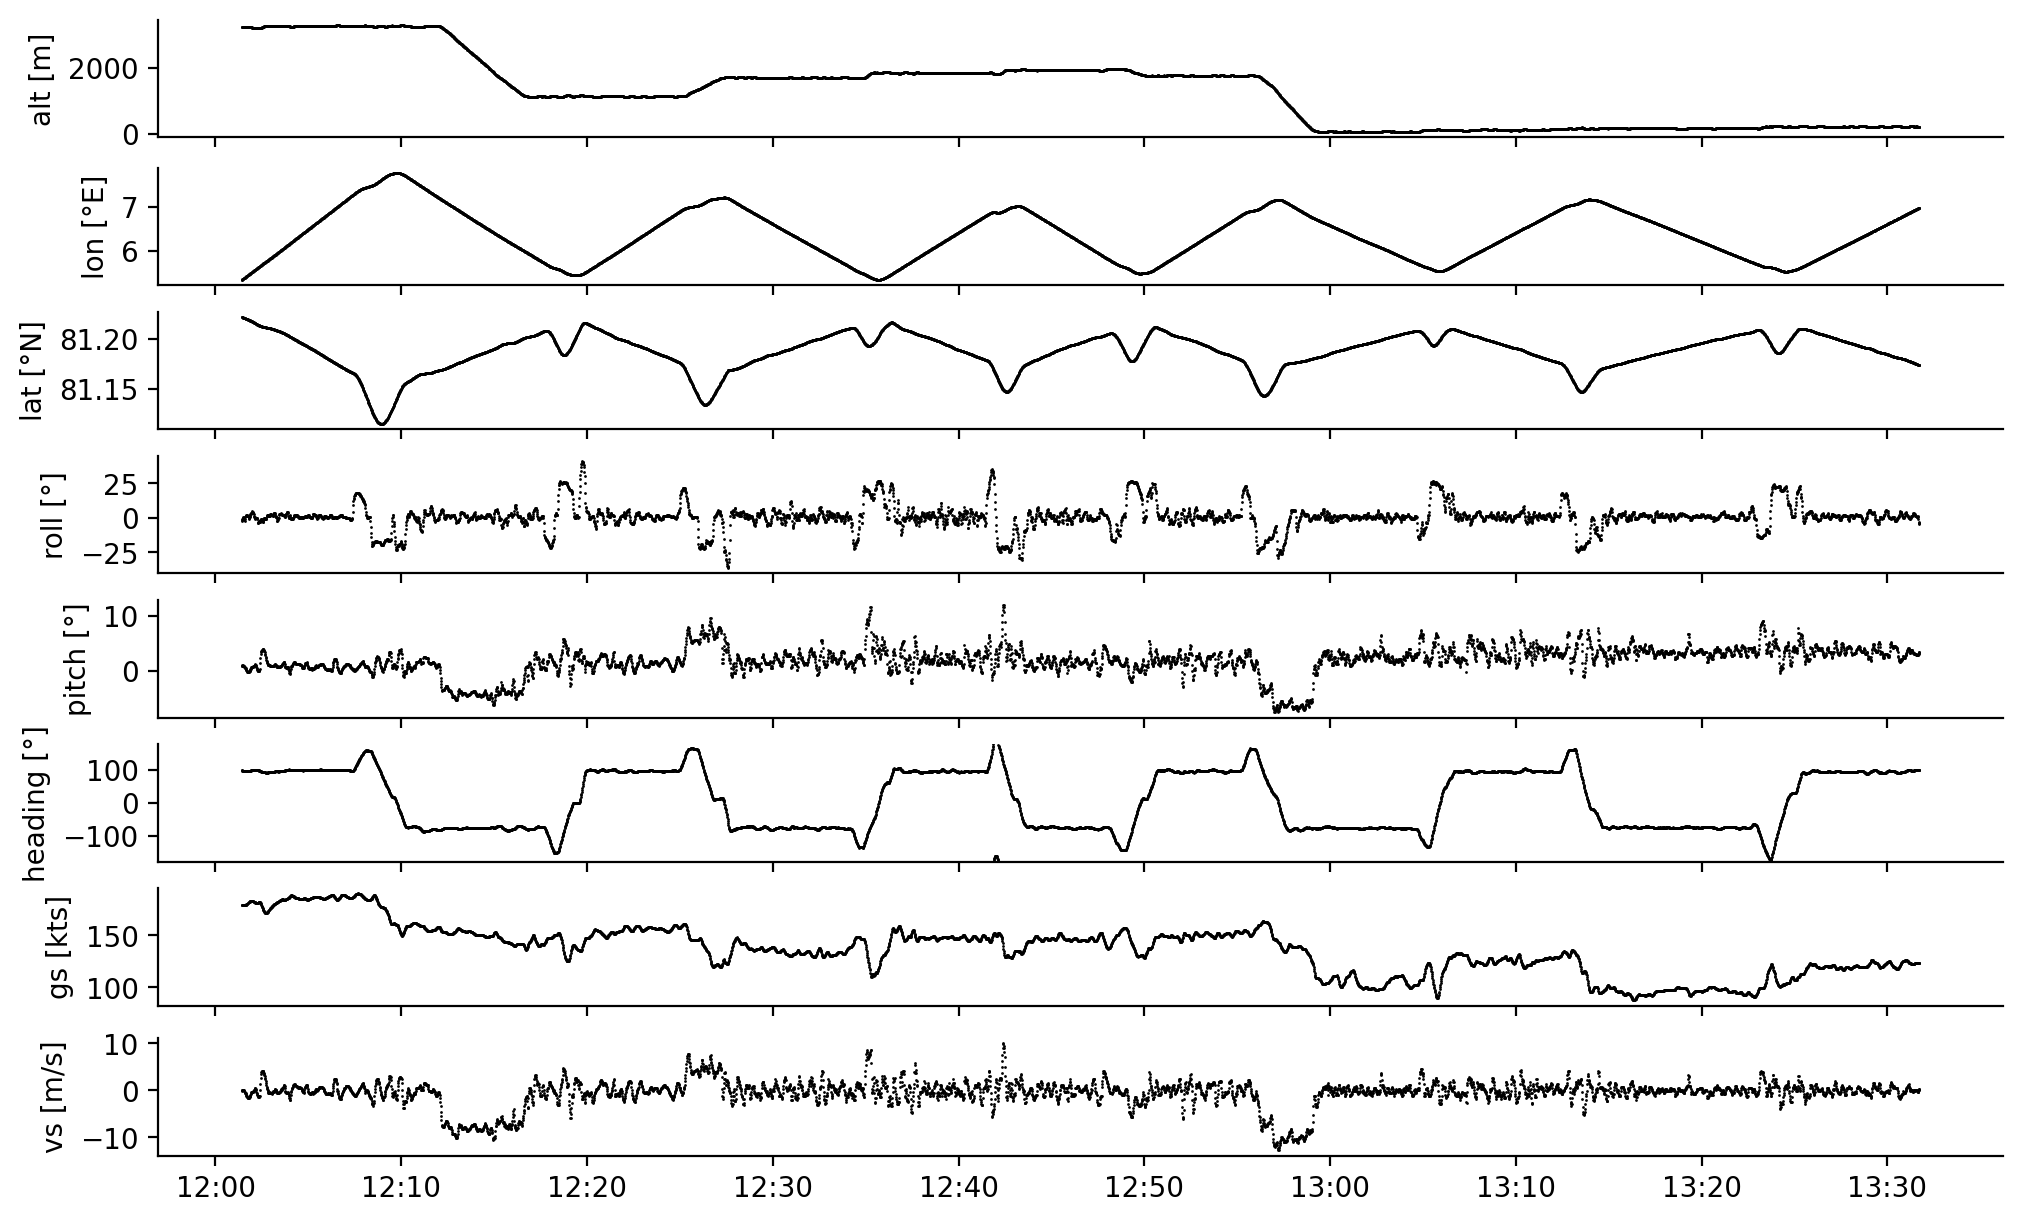

In [15]:
fig, ax = plt.subplots(8, 1, sharex=True)

kwargs = dict(s=1, linewidths=0, color='k')

ax[0].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['alt'], **kwargs)
ax[0].set_ylabel('alt [m]')

ax[1].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['lon'], **kwargs)
ax[1].set_ylabel('lon [°E]')

ax[2].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['lat'], **kwargs)
ax[2].set_ylabel('lat [°N]')

ax[3].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['roll'], **kwargs)
ax[3].set_ylabel('roll [°]')

ax[4].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['pitch'], **kwargs)
ax[4].set_ylabel('pitch [°]')

ax[5].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['heading'], **kwargs)
ax[5].set_ylim(-180, 180)
ax[5].set_ylabel('heading [°]')

ax[6].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['gs'], **kwargs)
ax[6].set_ylabel('gs [kts]')

ax[7].scatter(ds_gps_ins_rt.time, ds_gps_ins_rt['vs'], **kwargs)
ax[7].set_ylabel('vs [m/s]')

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()